<a href="https://colab.research.google.com/github/TanmoyGG/CVPR/blob/main/student_attendance_system(Transfer_learning).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Face Recognition with ResNet50 Transfer Learning


---

**Description:** Advanced face recognition using ResNet50 transfer learning with ImageNet weights. Two-phase training (frozen → fine-tuned) for high accuracy.



In [ ]:
!pip install tensorflow opencv-python numpy==1.26.4 matplotlib seaborn scikit-learn gdown -q

In [ ]:
#Imports & GPU Configuration
import os
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime
import csv
import gc
import zipfile

# TensorFlow/Keras imports
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress TF warnings
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'  # Force dynamic memory allocation

import tensorflow as tf
tf.get_logger().setLevel('ERROR')
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, top_k_accuracy_score
import seaborn as sns


# GPU/CPU CONFIGURATION - KAGGLE T4 x2 (30GB Total)

print("Checking for GPU...")
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    try:
        # Kaggle T4 Configuration: 15GB per GPU, allocate 12GB per GPU (leave 3GB margin)
        GPU_MEMORY_PER_GPU = 12000  # 12GB per T4

        for gpu in gpus:
            try:
                tf.config.set_logical_device_configuration(
                    gpu,
                    [tf.config.LogicalDeviceConfiguration(memory_limit=GPU_MEMORY_PER_GPU)]
                )
            except RuntimeError:
                tf.config.experimental.set_memory_growth(gpu, True)

        print(f" GPU DETECTED: {len(gpus)} device(s)")
        for i, gpu in enumerate(gpus):
            print(f"  GPU {i}: {gpu}")
        print(f"  Memory per GPU: {GPU_MEMORY_PER_GPU / 1000:.1f} GB")
        print(f" GPU ACCELERATION ENABLED! ")
    except RuntimeError as e:
        print(f" GPU configuration error: {e}")
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
else:
    print(" No GPU detected. Using CPU for training")

2026-01-06 06:02:44.304036: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767679364.326711    2457 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767679364.333534    2457 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Checking for GPU...
✓ GPU DETECTED: 2 device(s)
  GPU 0: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
  GPU 1: PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')
  Memory per GPU: 12.0 GB
✓ GPU ACCELERATION ENABLED! 🚀


In [ ]:
#Configuration & Path Setup
IMG_SIZE = 160
BATCH_SIZE = 16
EPOCHS = 120
MIN_CONFIDENCE = 0.85  # 85% threshold to reduce false positives
RANDOM_STATE = 42

# ========== LOAD MODEL ONLY MODE ==========

LOAD_MODEL_ONLY = False  # Change to True after training once


# Check if running on Kaggle
IS_KAGGLE = os.path.exists('/kaggle/input')

if IS_KAGGLE:
    # Running on Kaggle
    BASE_DIR = Path('/kaggle/working')
    KAGGLE_INPUT = Path('/kaggle/input')
    print("\n✓ Running on Kaggle")
    print(f"Working directory: {BASE_DIR}")
    print(f"Input directory: {KAGGLE_INPUT}")
else:
    # Running locally
    BASE_DIR = Path.cwd()
    print("\n✓ Running locally")
    print(f"Working directory: {BASE_DIR}")

MODEL_DIR = BASE_DIR / 'models'
ATTENDANCE_DIR = BASE_DIR / 'attendance_logs'
MODEL_DIR.mkdir(exist_ok=True)
ATTENDANCE_DIR.mkdir(exist_ok=True)
SAVED_MODEL_PATH = MODEL_DIR / 'resnet50_model.keras'

print("\n" + "=" * 50)
print("Face Recognition - ResNet50 Transfer Learning")
print("=" * 50)
print(f"TensorFlow Version: {tf.__version__}")
print(f"OpenCV Version: {cv2.__version__}")
print(f"Device: {'GPU' if gpus else 'CPU'}")
print(f"LOAD_MODEL_ONLY: {LOAD_MODEL_ONLY}")
print(f"Image Size: {IMG_SIZE}x{IMG_SIZE}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Epochs: {EPOCHS}")
print(f"Confidence Threshold: {MIN_CONFIDENCE * 100}%")
print("=" * 50)


✓ Running on Kaggle
Working directory: /kaggle/working
Input directory: /kaggle/input

Face Recognition - ResNet50 Transfer Learning
TensorFlow Version: 2.18.0
OpenCV Version: 4.11.0
Device: GPU
LOAD_MODEL_ONLY: False
Image Size: 160x160
Batch Size: 16
Epochs: 120
Confidence Threshold: 85.0%


In [ ]:
#Dataset Folder Search (dataset_processed)
print("\n" + "=" * 50)
print("Searching for dataset_processed...")
print("=" * 50)

DATASET_DIR = None

if IS_KAGGLE:
    # Search for dataset_processed folder in Kaggle environment
    possible_dataset_paths = []

    # Direct paths in both input and working directories
    possible_dataset_paths.extend([
        KAGGLE_INPUT / 'dataset_processed',
        KAGGLE_INPUT / 'dataset-processed',
        BASE_DIR / 'dataset_processed',
        BASE_DIR / 'dataset-processed'
    ])

    # Search in extracted ZIP directories in /kaggle/working
    if BASE_DIR.exists():
        for item in BASE_DIR.glob('*/'):
            if item.is_dir():
                possible_dataset_paths.extend([
                    item / 'dataset_processed',
                    item / 'dataset-processed',
                    item  # The extracted folder itself might contain student folders
                ])

    # Search all subdirectories in /kaggle/input for dataset_processed
    if KAGGLE_INPUT.exists():
        for item in KAGGLE_INPUT.glob('*/'):
            possible_dataset_paths.extend([
                item / 'dataset_processed',
                item / 'dataset-processed',
                item  # Try parent directories (might contain student folders directly)
            ])

            # Also check subdirectories
            if item.is_dir():
                for subitem in item.glob('*/'):
                    if 'dataset_processed' in subitem.name or 'dataset-processed' in subitem.name:
                        possible_dataset_paths.append(subitem)

    # Remove duplicates
    seen = set()
    unique_paths = []
    for path in possible_dataset_paths:
        if str(path) not in seen:
            seen.add(str(path))
            unique_paths.append(path)

    # Check which path exists and has student folders
    for path in unique_paths:
        if path.exists():
            # Check if this path contains directories (student folders)
            subdirs = [d for d in path.iterdir() if d.is_dir()]

            if subdirs:
                # Quick check: do these subdirs contain image files?
                has_images = False
                for subdir in subdirs[:5]:  # Check first 5 subdirs
                    images = list(subdir.glob('*.jpg')) + list(subdir.glob('*.jpeg')) + list(subdir.glob('*.png'))
                    if images:
                        has_images = True
                        break

                if has_images:
                    DATASET_DIR = path
                    print(f"✓ FOUND dataset_processed at: {path}")
                    print(f"  Contains {len(subdirs)} student folders")
                    # Show sample
                    for i, subdir in enumerate(subdirs[:5], 1):
                        images = list(subdir.glob('*.jpg')) + list(subdir.glob('*.jpeg')) + list(subdir.glob('*.png'))
                        print(f"  {i}. {subdir.name} ({len(images)} images)")
                    if len(subdirs) > 5:
                        print(f"  ... and {len(subdirs) - 5} more folders")
                    break

    if DATASET_DIR is None:
        print(" Could not find dataset_processed folder")
        print("\n KAGGLE INSTRUCTIONS:")
        print("   1. Go to your Kaggle notebook")
        print("   2. Click 'Add Input' button (top right)")
        print("   3. Select your 'dataset_processed' dataset")
        print("   4. Run the cell again")
        raise FileNotFoundError("Dataset directory not found")
else:
    # Running locally
    DATASET_DIR = BASE_DIR / 'dataset_processed'

    if not DATASET_DIR.exists():
        print(f" Dataset directory NOT found: {DATASET_DIR}")
        print("\n LOCAL INSTRUCTIONS:")
        print(f"   1. Create 'dataset_processed' folder in: {BASE_DIR}")
        print("   2. Copy your student face image folders there")
        print("   3. Run the cell again")
        raise FileNotFoundError(f"Dataset directory not found: {DATASET_DIR}")
    else:
        print(f"✓ Dataset directory found: {DATASET_DIR}")


Searching for dataset_processed...
✓ FOUND dataset_processed at: /kaggle/input/dataset-processed/dataset_processed
  Contains 66 student folders
  1. 22-48582-3 (20 images)
  2. 22-46275-1 (20 images)
  3. 22-47898-2 (20 images)
  4. 22-48569-3 (20 images)
  5. 22-49852-3 (20 images)
  ... and 61 more folders


In [ ]:
# Verify Dataset Structure
print("\n" + "=" * 50)
print("Dataset Structure Verification")
print("=" * 50)

if DATASET_DIR.exists():
    student_dirs = sorted([d for d in DATASET_DIR.iterdir() if d.is_dir()])
    print(f"\n✓ Dataset directory found: {DATASET_DIR}")
    print(f"✓ Number of student folders: {len(student_dirs)}")

    if student_dirs:
        print(f"\nStudent folders (showing first 10):")
        for i, student_dir in enumerate(student_dirs[:10]):
            images = list(student_dir.glob('*.jpg')) + list(student_dir.glob('*.png')) + list(student_dir.glob('*.jpeg'))
            status = "✓" if images else "⚠"
            print(f"  {status} {student_dir.name:20} - {len(images):3} images")

        if len(student_dirs) > 10:
            print(f"  ... and {len(student_dirs) - 10} more")

        # Count total images
        all_images = []
        for student_dir in student_dirs:
            all_images.extend(student_dir.glob('*.jpg'))
            all_images.extend(student_dir.glob('*.png'))
            all_images.extend(student_dir.glob('*.jpeg'))

        print(f"\n📊 Summary:")
        print(f"   Total students: {len(student_dirs)}")
        print(f"   Total images: {len(all_images)}")
        print(f"   Average per student: {len(all_images) / len(student_dirs):.1f}")
else:
    print(f" Dataset directory NOT found: {DATASET_DIR}")


Dataset Structure Verification

✓ Dataset directory found: /kaggle/input/dataset-processed/dataset_processed
✓ Number of student folders: 66

Student folders (showing first 10):
  ✓ 21-45902-3           -  20 images
  ✓ 22-46138-1           -  20 images
  ✓ 22-46139-1           -  20 images
  ✓ 22-46141-1           -  20 images
  ✓ 22-46275-1           -  20 images
  ✓ 22-46293-1           -  20 images
  ✓ 22-46342-1           -  20 images
  ✓ 22-46473-1           -  20 images
  ✓ 22-46536-1           -  20 images
  ✓ 22-46590-1           -  20 images
  ... and 56 more

📊 Summary:
   Total students: 66
   Total images: 1319
   Average per student: 20.0


In [ ]:
# Load Dataset from Folders
def load_dataset_from_folders(dataset_path, img_size=(IMG_SIZE, IMG_SIZE)):
    """
    Load and preprocess images from the dataset directory.
    Each subfolder represents a class (student).

    Args:
        dataset_path: Path to dataset directory
        img_size: Target image size

    Returns:
        X (images), y (labels), class_names (list of student IDs)
    """
    images = []
    labels = []
    class_names = []

    dataset_path = Path(dataset_path)

    if not dataset_path.exists():
        raise FileNotFoundError(f"Dataset directory not found: {dataset_path}")

    # Get all student directories (sorted for consistency)
    student_dirs = sorted([d for d in dataset_path.iterdir() if d.is_dir()])

    print(f"\nLoading dataset from: {dataset_path}")
    print(f"Found {len(student_dirs)} students:")

    for idx, student_dir in enumerate(student_dirs):
        student_id = student_dir.name
        class_names.append(student_id)

        # Get all image files
        image_files = list(student_dir.glob('*.jpg')) + list(student_dir.glob('*.png')) + list(student_dir.glob('*.jpeg'))
        print(f"  [{idx}] {student_id}: {len(image_files)} images")

        for img_path in image_files:
            # Load image
            img = cv2.imread(str(img_path))

            if img is None:
                continue

            # Resize and convert BGR to RGB
            img = cv2.resize(img, img_size, interpolation=cv2.INTER_AREA)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            images.append(img)
            labels.append(idx)

    # Convert to numpy arrays
    X = np.array(images, dtype=np.float32)
    y = np.array(labels, dtype=np.int32)

    print(f"\nDataset loaded successfully!")
    print(f"  Total images: {len(X)}")
    print(f"  Image shape: {X.shape[1:]}")
    print(f"  Number of classes: {len(class_names)}")

    return X, y, class_names


print("\n" + "=" * 50)
print("Loading Dataset...")
print("=" * 50)

X, y, CLASS_NAMES = load_dataset_from_folders(DATASET_DIR, img_size=(IMG_SIZE, IMG_SIZE))
NUM_CLASSES = len(CLASS_NAMES)

print(f"\n✓ Class names (first 10): {CLASS_NAMES[:10]}")
if NUM_CLASSES > 10:
    print(f"  ... and {NUM_CLASSES - 10} more classes")

# Clean up
gc.collect()


Loading Dataset...

Loading dataset from: /kaggle/input/dataset-processed/dataset_processed
Found 66 students:
  [0] 21-45902-3: 20 images
  [1] 22-46138-1: 20 images
  [2] 22-46139-1: 20 images
  [3] 22-46141-1: 20 images
  [4] 22-46275-1: 20 images
  [5] 22-46293-1: 20 images
  [6] 22-46342-1: 20 images
  [7] 22-46473-1: 20 images
  [8] 22-46536-1: 20 images
  [9] 22-46590-1: 20 images
  [10] 22-46666-1: 20 images
  [11] 22-46679-1: 20 images
  [12] 22-46887-1: 20 images
  [13] 22-46945-1: 20 images
  [14] 22-46983-1: 20 images
  [15] 22-47180-1: 20 images
  [16] 22-47294-1: 20 images
  [17] 22-47402-2: 20 images
  [18] 22-47884-2: 20 images
  [19] 22-47892-2: 20 images
  [20] 22-47894-2: 20 images
  [21] 22-47898-2: 20 images
  [22] 22-47925-2: 20 images
  [23] 22-47968-2: 20 images
  [24] 22-48055-2: 20 images
  [25] 22-48064-2: 20 images
  [26] 22-48091-2: 20 images
  [27] 22-48133-2: 20 images
  [28] 22-48205-2: 20 images
  [29] 22-48434-3: 20 images
  [30] 22-48541-3: 20 images

0

In [ ]:
# Cell 4: Train/Test Split
print("\n" + "=" * 50)
print("Splitting Dataset...")
print("=" * 50)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)

# Convert labels to categorical (one-hot encoding)
y_train_cat = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test_cat = keras.utils.to_categorical(y_test, NUM_CLASSES)

print(f"Training set: {len(X_train)} images")
print(f"Test set: {len(X_test)} images")
print(f"Number of classes: {NUM_CLASSES}")

print("\nApplying ResNet50 preprocessing...")
X_train_processed = preprocess_input(X_train.copy())
X_test_processed = preprocess_input(X_test.copy())
print("✓ Preprocessing complete")


Splitting Dataset...
Training set: 1055 images
Test set: 264 images
Number of classes: 66

Applying ResNet50 preprocessing...
✓ Preprocessing complete


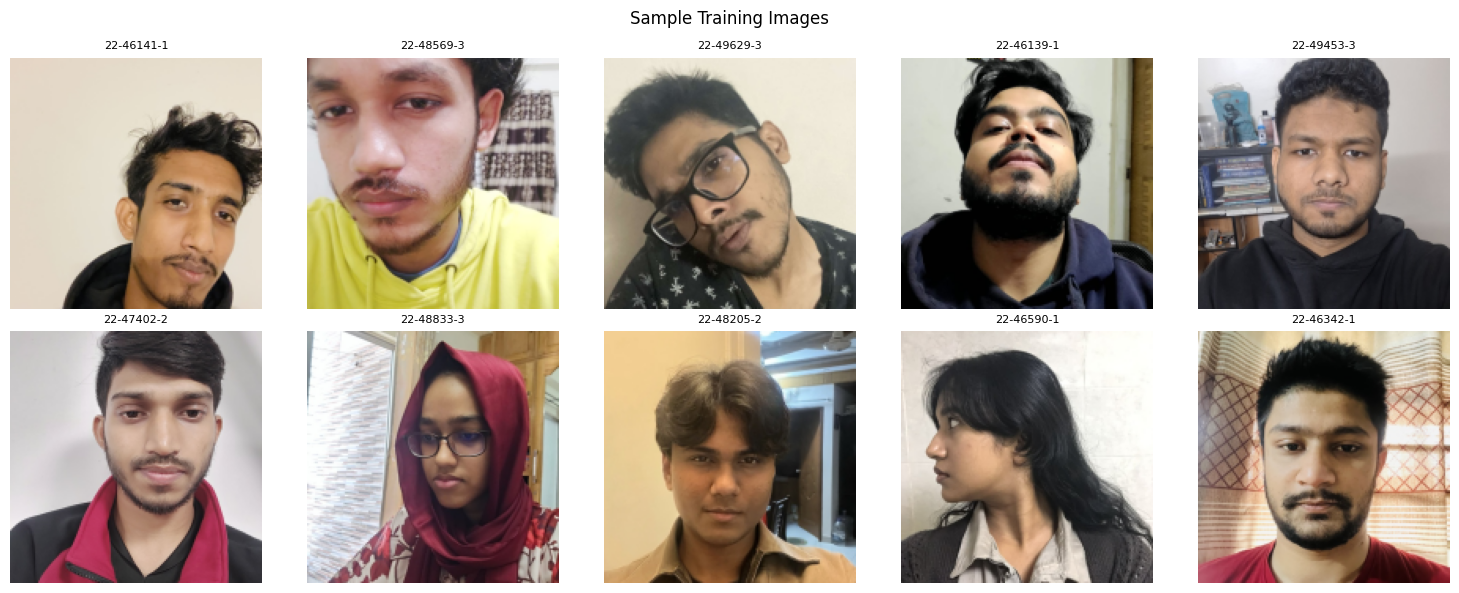

In [ ]:
# Sample Images
plt.figure(figsize=(15, 6))
for i in range(min(10, len(X_train))):
    plt.subplot(2, 5, i+1)
    plt.imshow(X_train[i].astype(np.uint8))
    plt.title(CLASS_NAMES[y_train[i]][:12], fontsize=8)
    plt.axis('off')
plt.suptitle('Sample Training Images')
plt.tight_layout()
plt.savefig(MODEL_DIR / 'sample_images.png')
plt.show()

In [ ]:
# Build or Load Model
print("\n" + "=" * 50)
print("Model Setup...")
print("=" * 50)

if LOAD_MODEL_ONLY and SAVED_MODEL_PATH.exists():
    print(f"Loading saved model: {SAVED_MODEL_PATH}")
    model = keras.models.load_model(SAVED_MODEL_PATH)
    base_model = None  # Not needed when loading
    print("✓ Model loaded successfully!")
    model.summary()
else:
    print("Building ResNet50 Transfer Learning Model...")
    print("  - Base: ResNet50 (ImageNet weights)")
    print("  - Input: 224x224x3")
    print(f"  - Output: {NUM_CLASSES} classes")

    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False  # Freeze base initially

    model = models.Sequential([
        layers.Resizing(224, 224),
        base_model,
        GlobalAveragePooling2D(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(NUM_CLASSES, activation='softmax')
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy', keras.metrics.TopKCategoricalAccuracy(k=5, name='top5_accuracy')]
    )

    print("\n✓ Model built successfully!")
    model.summary()


Model Setup...
Building ResNet50 Transfer Learning Model...
  - Base: ResNet50 (ImageNet weights)
  - Input: 224x224x3
  - Output: 66 classes


I0000 00:00:1767679440.750599    2457 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 12000 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1767679440.751447    2457 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 12000 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

✓ Model built successfully!


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing (Resizing)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)


Phase 1: Training with frozen ResNet50...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/60


I0000 00:00:1767679463.181688    2515 service.cc:148] XLA service 0x78d458014730 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1767679463.181736    2515 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1767679463.181741    2515 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1767679464.761673    2515 cuda_dnn.cc:529] Loaded cuDNN version 90300


 2/66 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 0.0469 - loss: 4.5212 - top5_accuracy: 0.2188  

I0000 00:00:1767679470.194167    2515 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.0458 - loss: 4.5173 - top5_accuracy: 0.1782
Epoch 1: val_accuracy improved from -inf to 0.25758, saving model to /kaggle/working/models/best_resnet50_model.keras
66/66 ━━━━━━━━━━━━━━━━━━━━ 40s 387ms/step - accuracy: 0.0464 - loss: 4.5109 - top5_accuracy: 0.1795 - val_accuracy: 0.2576 - val_loss: 3.0902 - val_top5_accuracy: 0.5379 - learning_rate: 0.0010
Epoch 2/60
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.2836 - loss: 2.8636 - top5_accuracy: 0.5891
Epoch 2: val_accuracy improved from 0.25758 to 0.67045, saving model to /kaggle/working/models/best_resnet50_model.keras
66/66 ━━━━━━━━━━━━━━━━━━━━ 9s 136ms/step - accuracy: 0.2840 - loss: 2.8622 - top5_accuracy: 0.5895 - val_accuracy: 0.6705 - val_loss: 1.7436 - val_top5_accuracy: 0.8485 - learning_rate: 0.0010
Epoch 3/60
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.4518 - loss: 2.2343 - top5_accuracy: 0.7170
Epoch 3: val_accuracy improved from 0.67045 to 0.76515,

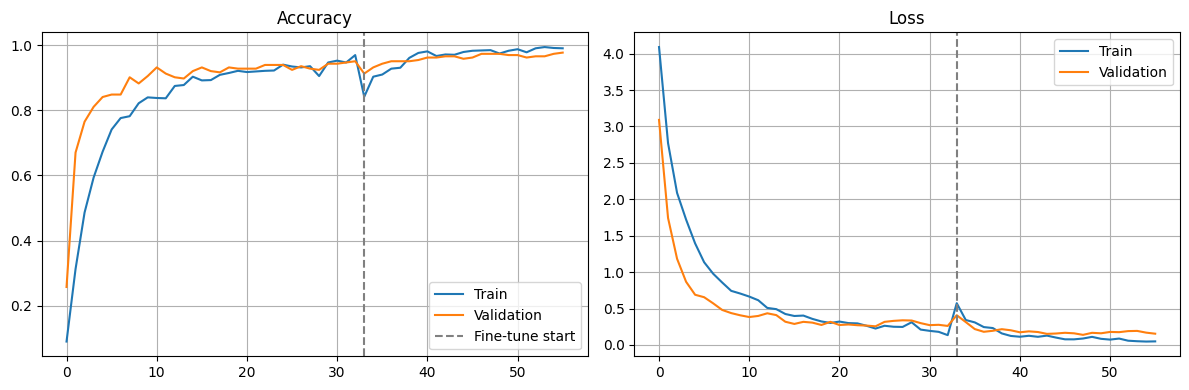

In [ ]:
# Training (skipped if LOAD_MODEL_ONLY=True)
if not LOAD_MODEL_ONLY:
    # Data Augmentation (TRAIN ONLY)
    train_datagen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.15,
        horizontal_flip=True,
        brightness_range=[0.8, 1.2]
    )

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-7, verbose=1),
        ModelCheckpoint(
            str(MODEL_DIR / 'best_resnet50_model.keras'),
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        )
    ]

    # Clear GPU memory
    gc.collect()
    if gpus:
        tf.keras.backend.clear_session()

    # Phase 1 - Train with Frozen Base
    print("\n" + "=" * 50)
    print("Phase 1: Training with frozen ResNet50...")
    print("=" * 50)

    history1 = model.fit(
        train_datagen.flow(X_train_processed, y_train_cat, batch_size=BATCH_SIZE),
        epochs=EPOCHS // 2,
        validation_data=(X_test_processed, y_test_cat),
        callbacks=callbacks
    )

    # Phase 2 - Fine-tune
    print("\n" + "=" * 50)
    print("Phase 2: Fine-tuning...")
    print("=" * 50)

    base_model.trainable = True
    for layer in base_model.layers[:50]:
        layer.trainable = False

    model.compile(optimizer=keras.optimizers.Adam(0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

    history2 = model.fit(
        train_datagen.flow(X_train_processed, y_train_cat, batch_size=BATCH_SIZE),
        epochs=EPOCHS // 2,
        validation_data=(X_test_processed, y_test_cat),
        callbacks=callbacks
    )

    model.save(SAVED_MODEL_PATH)
    print(f"\n✓ Model saved to: {SAVED_MODEL_PATH}")

    # Training History
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    acc = history1.history['accuracy'] + history2.history['accuracy']
    val_acc = history1.history['val_accuracy'] + history2.history['val_accuracy']
    loss = history1.history['loss'] + history2.history['loss']
    val_loss = history1.history['val_loss'] + history2.history['val_loss']

    axes[0].plot(acc, label='Train')
    axes[0].plot(val_acc, label='Validation')
    axes[0].axvline(len(history1.history['accuracy']), color='gray', linestyle='--', label='Fine-tune start')
    axes[0].set_title('Accuracy')
    axes[0].legend()
    axes[0].grid(True)

    axes[1].plot(loss, label='Train')
    axes[1].plot(val_loss, label='Validation')
    axes[1].axvline(len(history1.history['loss']), color='gray', linestyle='--')
    axes[1].set_title('Loss')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.savefig(MODEL_DIR / 'training_history.png')
    plt.show()
else:
    print("\n✓ LOAD_MODEL_ONLY=True: Skipping training, using saved model")

In [ ]:
# Comprehensive Evaluation
print("\n" + "=" * 50)
print(f"Evaluating Model ({NUM_CLASSES} Classes)")
print("=" * 50)

# Make predictions
y_pred_proba = model.predict(X_test_processed, verbose=0)
y_pred = np.argmax(y_pred_proba, axis=1)
y_pred_conf = np.max(y_pred_proba, axis=1)

print("\n📊 ACCURACY METRICS:")
print("=" * 50)

# 1. Overall accuracy
accuracy = np.mean(y_pred == y_test)
print(f"✓ Top-1 Accuracy: {accuracy * 100:.2f}%")

# 2. Top-5 accuracy
top5_acc = top_k_accuracy_score(y_test, y_pred_proba, k=min(5, NUM_CLASSES))
print(f"✓ Top-5 Accuracy: {top5_acc * 100:.2f}% (correct in top 5 predictions)")

# 3. High confidence accuracy
high_conf_mask = y_pred_conf >= MIN_CONFIDENCE
if high_conf_mask.sum() > 0:
    high_conf_acc = np.mean(y_pred[high_conf_mask] == y_test[high_conf_mask])
    print(f"\n✓ High Confidence (≥{MIN_CONFIDENCE*100:.0f}%) Accuracy: {high_conf_acc * 100:.2f}%")
    print(f"  Samples above threshold: {high_conf_mask.sum()} / {len(y_test)} ({high_conf_mask.sum()/len(y_test)*100:.1f}%)")
else:
    print(f"\n⚠ No predictions above {MIN_CONFIDENCE*100:.0f}% confidence threshold")

# 4. Average confidence
avg_conf = np.mean(y_pred_conf)
print(f"\n✓ Average Confidence: {avg_conf * 100:.2f}%")
print(f"  Min: {np.min(y_pred_conf) * 100:.2f}% | Max: {np.max(y_pred_conf) * 100:.2f}%")

# 5. Test loss
loss = model.evaluate(X_test_processed, y_test_cat, verbose=0)[0]
print(f"\n✓ Test Loss: {loss:.4f}")


Evaluating Model (66 Classes)

📊 ACCURACY METRICS:
✓ Top-1 Accuracy: 97.35%
✓ Top-5 Accuracy: 98.48% (correct in top 5 predictions)

✓ High Confidence (≥85%) Accuracy: 99.20%
  Samples above threshold: 251 / 264 (95.1%)

✓ Average Confidence: 97.48%
  Min: 28.19% | Max: 100.00%

✓ Test Loss: 0.1390


In [ ]:
# Classification Report
print("\n" + "=" * 50)
print("Classification Report")
print("=" * 50)
print(classification_report(y_test, y_pred, target_names=CLASS_NAMES, zero_division=0))


Classification Report
              precision    recall  f1-score   support

  21-45902-3       1.00      1.00      1.00         4
  22-46138-1       1.00      1.00      1.00         4
  22-46139-1       1.00      1.00      1.00         4
  22-46141-1       1.00      1.00      1.00         4
  22-46275-1       1.00      1.00      1.00         4
  22-46293-1       1.00      1.00      1.00         4
  22-46342-1       1.00      1.00      1.00         4
  22-46473-1       1.00      1.00      1.00         4
  22-46536-1       1.00      1.00      1.00         4
  22-46590-1       1.00      1.00      1.00         4
  22-46666-1       1.00      1.00      1.00         4
  22-46679-1       1.00      1.00      1.00         4
  22-46887-1       1.00      1.00      1.00         4
  22-46945-1       1.00      1.00      1.00         4
  22-46983-1       1.00      1.00      1.00         4
  22-47180-1       1.00      1.00      1.00         4
  22-47294-1       1.00      1.00      1.00         4
  22


Confusion Matrix


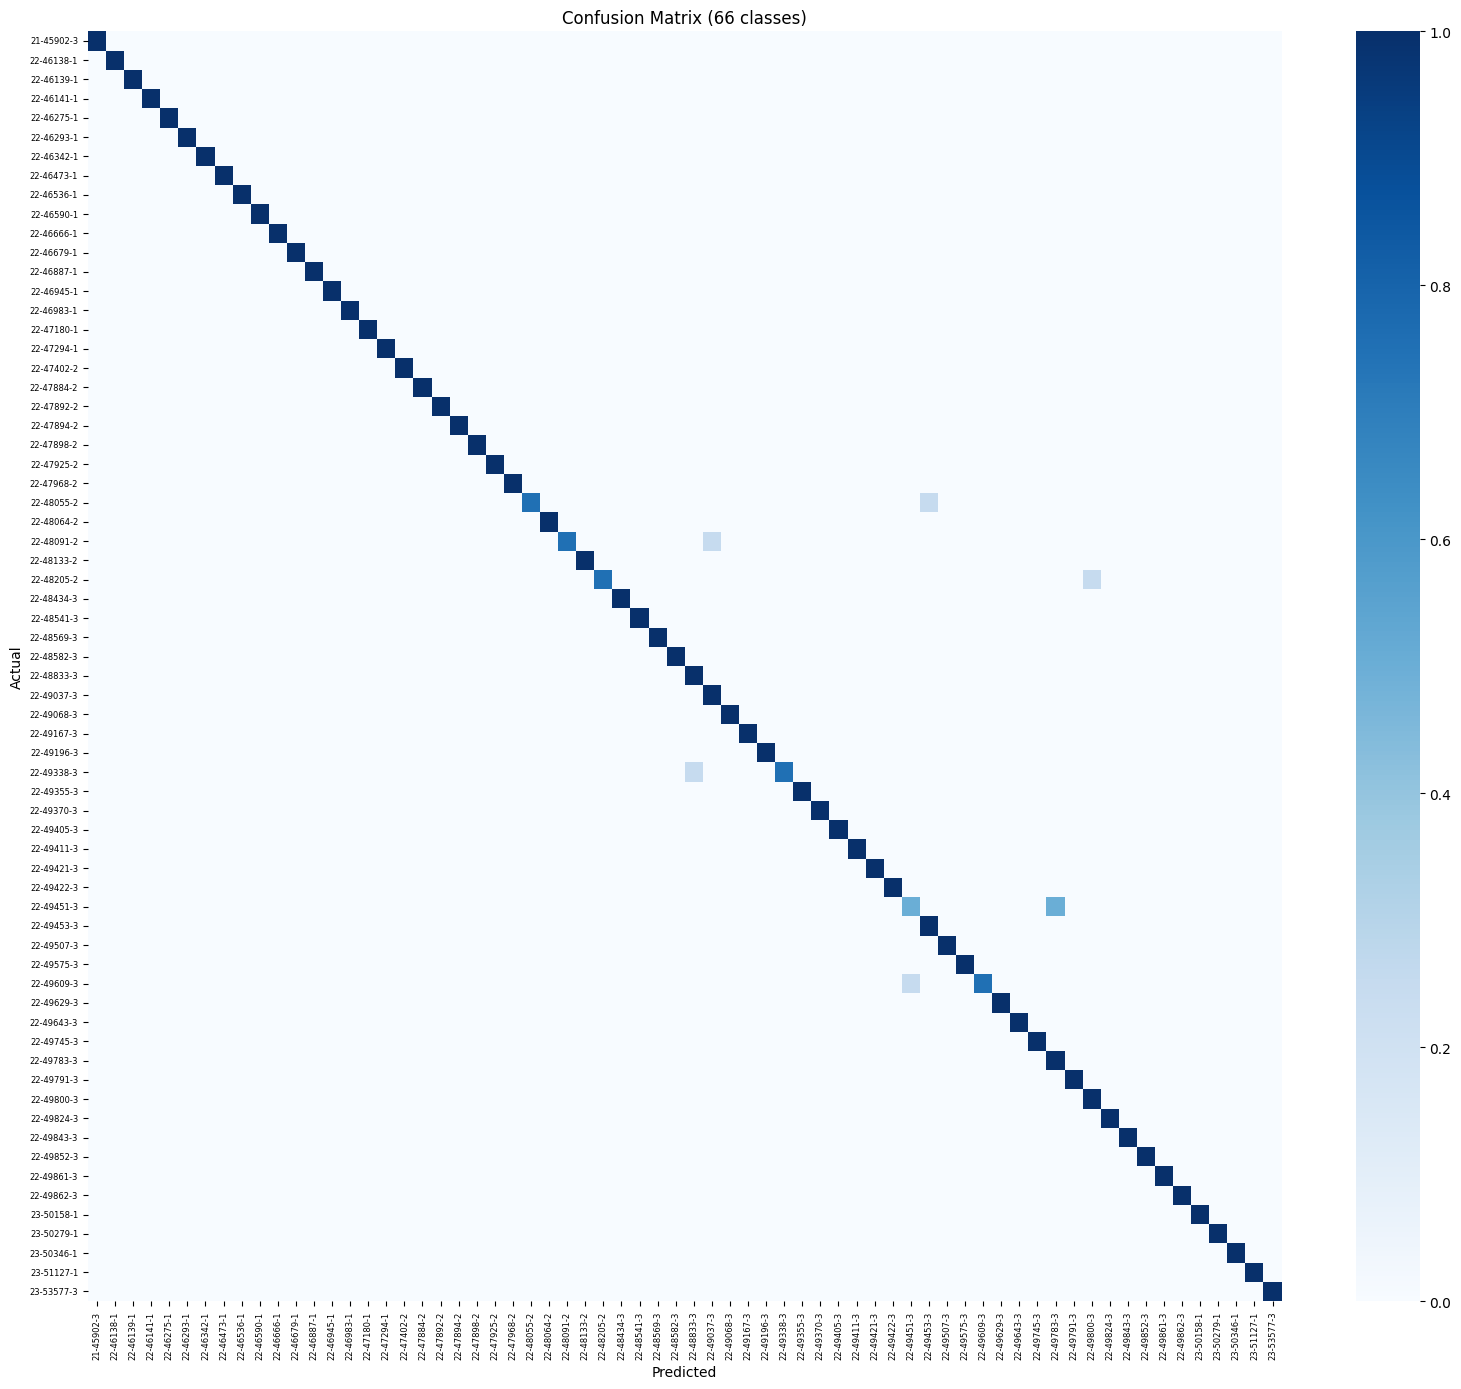


✓ Confusion matrix saved to: /kaggle/working/models/confusion_matrix.png


In [ ]:
# Confusion Matrix
print("\n" + "=" * 50)
print("Confusion Matrix")
print("=" * 50)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(16, 14))
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_norm = np.nan_to_num(cm_norm)
sns.heatmap(cm_norm, annot=False, cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.title(f'Confusion Matrix ({NUM_CLASSES} classes)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=90, fontsize=6)
plt.yticks(fontsize=6)
plt.tight_layout()
plt.savefig(MODEL_DIR / 'confusion_matrix.png', dpi=150)
plt.show()

print(f"\n✓ Confusion matrix saved to: {MODEL_DIR / 'confusion_matrix.png'}")


Confidence Distribution


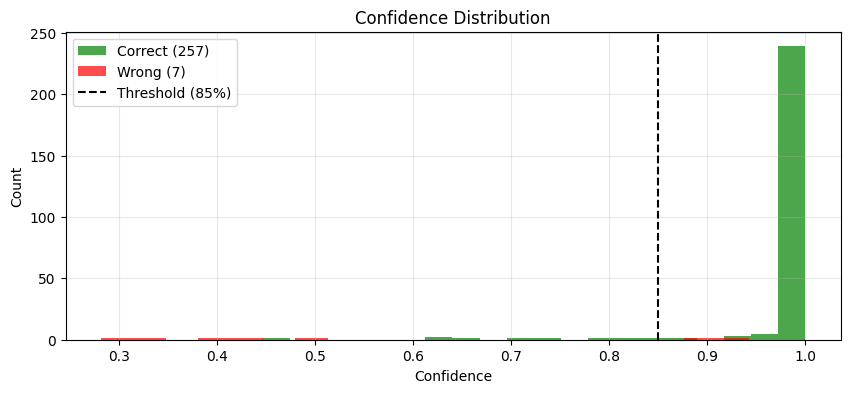


✓ Confidence distribution saved to: /kaggle/working/models/confidence_distribution.png


In [ ]:
# Confidence Distribution
print("\n" + "=" * 50)
print("Confidence Distribution")
print("=" * 50)

plt.figure(figsize=(10, 4))
correct = y_pred == y_test
plt.hist(y_pred_conf[correct], bins=20, alpha=0.7, label=f'Correct ({correct.sum()})', color='green')
plt.hist(y_pred_conf[~correct], bins=20, alpha=0.7, label=f'Wrong ({(~correct).sum()})', color='red')
plt.axvline(MIN_CONFIDENCE, color='black', linestyle='--', label=f'Threshold ({MIN_CONFIDENCE:.0%})')
plt.xlabel('Confidence')
plt.ylabel('Count')
plt.title('Confidence Distribution')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig(MODEL_DIR / 'confidence_distribution.png')
plt.show()

print(f"\n✓ Confidence distribution saved to: {MODEL_DIR / 'confidence_distribution.png'}")


Per-Class Accuracy


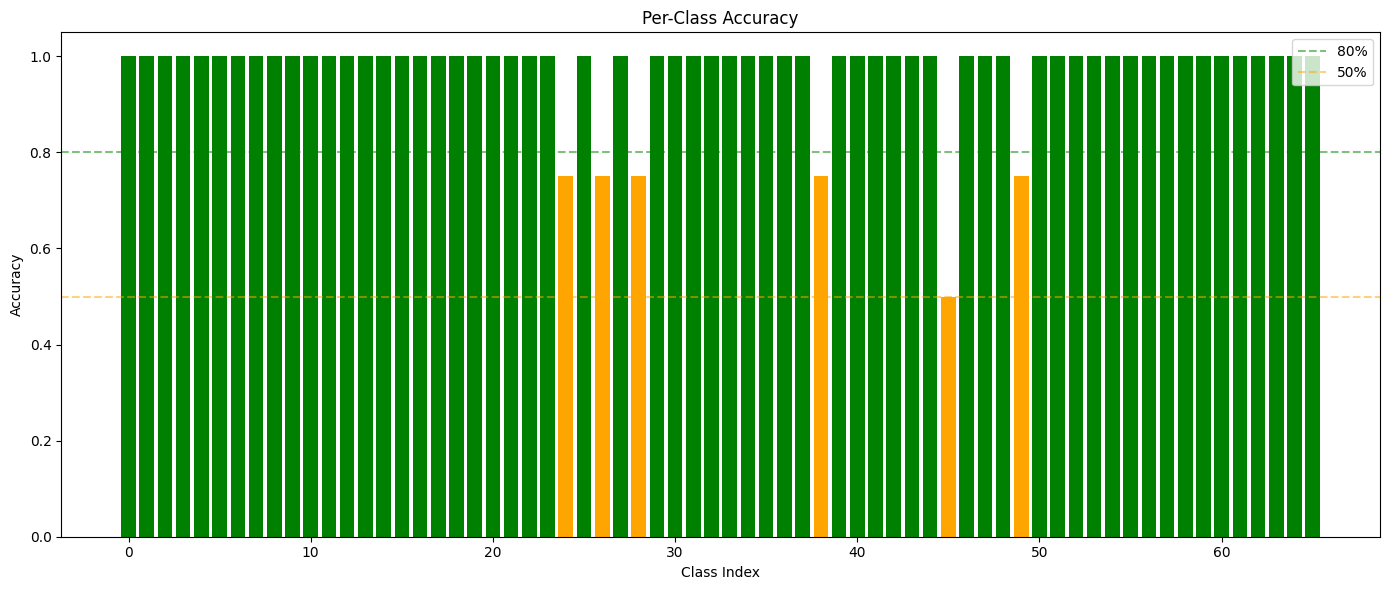


✓ Per-class accuracy saved to: /kaggle/working/models/per_class_accuracy.png


In [ ]:
# Per-Class Accuracy
print("\n" + "=" * 50)
print("Per-Class Accuracy")
print("=" * 50)

per_class_acc = []
for i in range(NUM_CLASSES):
    mask = y_test == i
    if mask.sum() > 0:
        per_class_acc.append((y_pred[mask] == i).mean())
    else:
        per_class_acc.append(0)

plt.figure(figsize=(14, 6))
colors = ['green' if a >= 0.8 else 'orange' if a >= 0.5 else 'red' for a in per_class_acc]
plt.bar(range(NUM_CLASSES), per_class_acc, color=colors)
plt.axhline(0.8, color='green', linestyle='--', alpha=0.5, label='80%')
plt.axhline(0.5, color='orange', linestyle='--', alpha=0.5, label='50%')
plt.xlabel('Class Index')
plt.ylabel('Accuracy')
plt.title('Per-Class Accuracy')
plt.legend()
plt.tight_layout()
plt.savefig(MODEL_DIR / 'per_class_accuracy.png')
plt.show()

print(f"\n✓ Per-class accuracy saved to: {MODEL_DIR / 'per_class_accuracy.png'}")

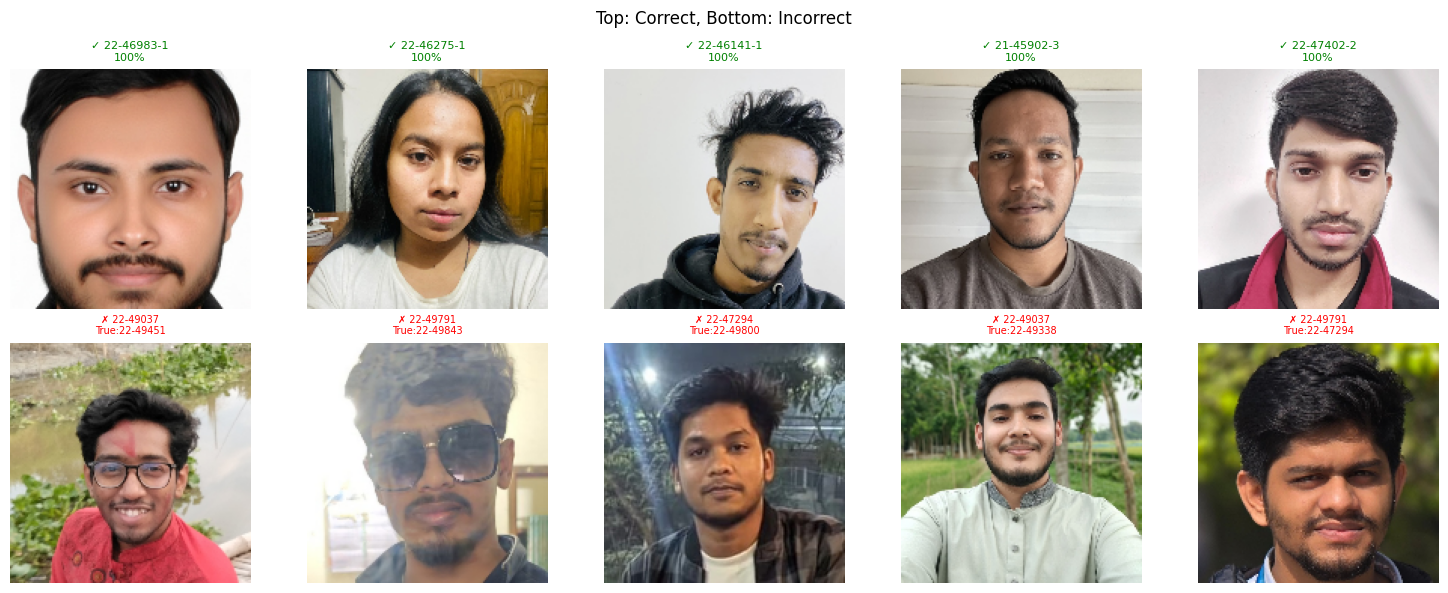

In [ ]:
# Sample Predictions
print("\n" + "=" * 50)
print("Sample Predictions")
print("=" * 50)

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
correct_mask = y_pred == y_test
correct_idx = np.where(correct_mask)[0][:5]
wrong_idx = np.where(~correct_mask)[0][:5]

for i, idx in enumerate(correct_idx):
    axes[0, i].imshow(X_test[idx].astype(np.uint8))
    axes[0, i].set_title(f'✓ {CLASS_NAMES[y_test[idx]][:10]}\n{y_pred_conf[idx]:.0%}', color='green', fontsize=8)
    axes[0, i].axis('off')

for i in range(5):
    if i < len(wrong_idx):
        idx = wrong_idx[i]
        axes[1, i].imshow(X_test[idx].astype(np.uint8))
        axes[1, i].set_title(f'✗ {CLASS_NAMES[y_pred[idx]][:8]}\nTrue:{CLASS_NAMES[y_test[idx]][:8]}', color='red', fontsize=7)
    axes[1, i].axis('off')

plt.suptitle('Top Row: Correct Predictions | Bottom Row: Incorrect Predictions')
plt.tight_layout()
plt.savefig(MODEL_DIR / 'sample_predictions.png')
plt.show()

print(f"\n✓ Sample predictions saved to: {MODEL_DIR / 'sample_predictions.png'}")

In [ ]:
# Cell 14: Real-Time Camera Attendance (Optional - Uncomment to use)
# print("\n" + "=" * 50)
# print("CAMERA ATTENDANCE (ResNet50)")
# print("Press 'q' to quit")
# print("=" * 50)
#
# face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
# cap = cv2.VideoCapture(0)
# attendance = {}
#
# while cap.isOpened():
#     ret, frame = cap.read()
#     if not ret:
#         break
#
#     # Detect ALL faces
#     gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
#     gray = cv2.equalizeHist(gray)
#     faces = face_cascade.detectMultiScale(gray, 1.1, 5, minSize=(30, 30))
#
#     for (x, y, w, h) in faces:
#         # Crop face with margin
#         margin = 0.1
#         x1, y1 = max(0, int(x - w*margin)), max(0, int(y - h*margin))
#         x2, y2 = min(frame.shape[1], int(x + w + w*margin)), min(frame.shape[0], int(y + h + h*margin))
#         face = frame[y1:y2, x1:x2]
#
#         # Preprocess for ResNet
#         face = cv2.resize(face, (IMG_SIZE, IMG_SIZE))
#         face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB).astype(np.float32)
#         face = preprocess_input(face)
#
#         # Predict
#         pred = model.predict(np.expand_dims(face, 0), verbose=0)[0]
#         idx, conf = np.argmax(pred), np.max(pred)
#         name = CLASS_NAMES[idx] if conf >= MIN_CONFIDENCE else f"Unknown ({CLASS_NAMES[idx]}?)"
#
#         # Mark attendance
#         if conf >= MIN_CONFIDENCE and name not in attendance:
#             attendance[name] = datetime.now()
#             print(f"✓ {name} present ({conf:.0%})")
#
#         # Draw
#         color = (0, 255, 0) if conf >= MIN_CONFIDENCE else (0, 0, 255)
#         cv2.rectangle(frame, (x, y), (x+w, y+h), color, 2)
#         cv2.putText(frame, f"{name}: {conf:.0%}", (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
#
#     cv2.putText(frame, f"Present: {len(attendance)}/{NUM_CLASSES}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,255), 2)
#     cv2.imshow('Attendance', frame)
#
#     if cv2.waitKey(1) & 0xFF == ord('q'):
#         break
#
# cap.release()
# cv2.destroyAllWindows()
# print(f"\nTotal: {len(attendance)}/{NUM_CLASSES} present")

print("\n" + "=" * 50)
print("TRAINING & EVALUATION COMPLETE!")
print("=" * 50)
print("\nTo run real-time camera attendance, uncomment the cell above.")
print("\nGenerated files:")
print(f"  - Model: {SAVED_MODEL_PATH}")
print(f"  - Training history: {MODEL_DIR / 'training_history.png'}")
print(f"  - Confusion matrix: {MODEL_DIR / 'confusion_matrix.png'}")
print(f"  - Sample predictions: {MODEL_DIR / 'sample_predictions.png'}")
print("=" * 50)


CAMERA ATTENDANCE (ResNet50)
Press 'q' to quit

Total: 0/66 present


[ WARN:0@6259.984] global cap_v4l.cpp:913 open VIDEOIO(V4L2:/dev/video0): can't open camera by index
[ERROR:0@6259.984] global obsensor_uvc_stream_channel.cpp:158 getStreamChannelGroup Camera index out of range
